<a href="https://colab.research.google.com/github/iceaiai/CS-team/blob/main/Final_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [34]:
!pip install opencv-python pillow
!pip install segmentation_models_pytorch

#1. Setup and Imports
Import all necessary libraries and ensure that the environment is correctly set up

In [35]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split
from torchvision.transforms import *
from PIL import Image
from matplotlib import pyplot as plt
import random
from tqdm import tqdm
import torch.optim as optim
from torchvision import transforms, models
import os
import numpy as np
import kagglehub
import shutil


original_path = kagglehub.dataset_download("batuhanyil/electron-microscopy-particle-segmentation")
print("Original Path to dataset files:", original_path)
path = "/content/electron-microscopy-particle-segmentation"
shutil.move(original_path, path)
print(f"Dataset moved to: {path}")
!ls {path}

100%|██████████| 113M/113M [00:00<00:00, 143MB/s]

Extracting files...


Original Path to dataset files: /root/.cache/kagglehub/datasets/batuhanyil/electron-microscopy-particle-segmentation/versions/1
Dataset moved to: /content/electron-microscopy-particle-segmentation
1  images  segmaps


In [36]:
print("Contents of the dataset folder:")
print(os.listdir(path))

Contents of the dataset folder:
['images', '1', 'segmaps']


#2.Configuration class or dictionary to make hyperparameters easily tunable
Note: 'image' folder contains SEM/TEM images. 'segmaps' contained the labelled masks.They are also available in our GT github.

In [46]:
class Config:
    # Data parameters
    image_folder = os.path.join(path, 'images')
    mask_folder = os.path.join(path, 'segmaps')
    resize = (512, 512) # it will be very painful if the image height and width are not the same!!!!

    # Training hyperparameters
    num_epochs = 50
    batch_size = 16
    learning_rate = 1e-3
    momentum = 0.9
    weight_decay = 1e-4

    # Model parameters
    num_classes = 1  # For binary segmentation
    kernel_size = 3
    stride = 1
    padding = 1

    # Device configuration
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

config = Config()
print(f'current device = {config.device}')


current device = cuda


#3. Dataset preparation:


In [47]:
#Class for preparing data
class ImageDataset:
    def __init__(self, image_folder, mask_folder,transform =None,binary=False):
        self.image_folder = image_folder
        self.mask_folder = mask_folder
        self.image_files = sorted(os.listdir(image_folder))
        self.mask_files = sorted(os.listdir(mask_folder))
        self.transform = transform
        self.binary = binary
    def binary_transform(self, mask): # We only deal with one class
        # Transform mask to 1,0. 1 for masked area, 0 for not
        mask_array = np.array(mask)
        binary_mask = (mask_array != 0).astype(np.uint8)
        return Image.fromarray(binary_mask)

    def __len__(self): #Dunder method, usage: len(obj)
      return len(self.image_files)
    def __getitem__(self, idx): #Dunder method, usage: obj[idx]
      image_path = os.path.join(self.image_folder, self.image_files[idx])
      mask_path = os.path.join(self.mask_folder, self.mask_files[idx])
      image = Image.open(image_path).convert('L')
      mask = Image.open(mask_path).convert('L')
      if self.binary:
          mask = self.binary_transform(mask)
      if self.transform:
          image, mask = self.transform(image, mask)
      return image, mask
    def plot_figure(self, overlay=False, mask=True, binary=False, idx=None):
        """
        overlay: overlapping the original and masked images
        mask: display mask images
        idx: index or list of indices of the images to plot
        """
        if idx is None:
            idx = [0]
        elif isinstance(idx, int):
            idx = [idx]
        idx = [i for i in idx if i < len(self.image_files)]
        total_cols = 3 if mask and overlay else 2 if mask else 1
        total_rows = len(idx)
        fig, axes = plt.subplots(total_rows, total_cols, figsize=(5 * total_cols, 5 * total_rows))

        if total_rows == 1:
            axes = [axes]

        for i, file_idx in enumerate(idx):
            img, mask_img = self[file_idx]

            # Convert tensors to numpy arrays
            img_np = img.squeeze(0).numpy()  # Squeeze channel for grayscale
            mask_np = mask_img.numpy()  # mask is already single-channel after transform

            ax_row = axes[i] if total_rows > 1 else axes

            # Display the image
            ax_row[0].imshow(img_np, cmap='gray')
            ax_row[0].set_title(f"Image {self.image_files[file_idx]}")
            ax_row[0].axis('off')

            if mask:
                # Display the mask
                ax_row[1].imshow(mask_np, cmap='inferno')
                ax_row[1].set_title(f"Mask {self.mask_files[file_idx]}")
                ax_row[1].axis('off')

                if overlay:
                    # Display the overlay
                    ax_row[2].imshow(img_np, cmap='gray', alpha=0.9)
                    ax_row[2].imshow(mask_np, cmap='inferno', alpha=0.4)
                    ax_row[2].set_title(f"Overlay {file_idx}")
                    ax_row[2].axis('off')

        plt.tight_layout()
        plt.show()

#Class for transforming data:
"""
  1. Resizing;
  2. Converting to tensor;
"""
class SegmentationTransform:
    def __init__(self, resize=None):
        self.resize = resize
        self.image_resize = transforms.Resize(resize)
        self.mask_resize = transforms.Resize(resize, interpolation=Image.NEAREST)

    def __call__(self, image, mask):
        image = self.image_resize(image)
        image_tensor = torch.tensor(np.array(image), dtype=torch.float32).unsqueeze(0) / 255.0
        mask = self.mask_resize(mask)
        mask_array = np.array(mask)
        binary_mask = (mask_array > 0).astype(np.float32)
        mask_tensor = torch.tensor(binary_mask)
        return image_tensor, mask_tensor




#4. Data Loader

In [48]:
#Assign image and mask folder. Test the imagedata set class:
transform = SegmentationTransform(resize = config.resize) # can add resize if needed but not recommended
dataset = ImageDataset(config.image_folder, config.mask_folder, transform=transform, binary=True)
dataset_size = len(dataset)
train_size = int(0.6 * dataset_size)
val_size = int(0.2 * dataset_size)
test_size = dataset_size - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(
    dataset, [train_size, val_size, test_size], generator=torch.Generator().manual_seed(42))

# Data loaders
"""
You can set:
batch size;
shuffle the data or not
num_workers: higher value speeding up the loading process.

"""

train_loader = DataLoader(train_dataset,
              batch_size=config.batch_size,
              shuffle=True,
              num_workers=4
              )
val_loader = DataLoader(val_dataset,
              batch_size=config.batch_size, shuffle=False, num_workers=4
              )
test_loader = DataLoader(test_dataset,
              batch_size=config.batch_size, shuffle=False, num_workers=4
              )

#dataset.plot_figure(overlay=True, mask=True, binary=True,idx=[10,11,12,13,14,15,16,17,20, 21, 22, 23, 24, 25])

In [49]:
example_img1,example_mask1 = dataset[1]

example_mask1_np = np.array(example_mask1)
np.max(example_mask1_np)


1.0

# 5. Model preparation


##5.1 VGG-16


In [50]:
#Architectures of VGG-16:
"""
# input: (1,1,512,512)
(0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
(1): ReLU(inplace=True)
(2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
(3): ReLU(inplace=True)
(4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)# Pool1(1,64,256,256)
(5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
(6): ReLU(inplace=True)
(7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
(8): ReLU(inplace=True)
(9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)#Pool2 (1,128,128,128)
(10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
(11): ReLU(inplace=True)
(12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
(13): ReLU(inplace=True)
(14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
(15): ReLU(inplace=True)
(16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False) #Pool3 (1,256,64,64)
(17): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
(18): ReLU(inplace=True)
(19): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
(20): ReLU(inplace=True)
(21): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
(22): ReLU(inplace=True)
(23): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False) #Pool4(1,512,32,32)
(24): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
(25): ReLU(inplace=True)
(26): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
(27): ReLU(inplace=True)
(28): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
(29): ReLU(inplace=True)
(30): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False) #Pool5(1,512,16,16)
)
"""
#FCN only, discard FCL
class FCN8s_VGG16(nn.Module):
    def __init__(self, num_classes):
        super(FCN8s_VGG16, self).__init__()
        vgg = models.vgg16(pretrained=True) # VGG from pytorch

        vgg.features[0] = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1) #remember we only have one channel not RGB, see [0] layer above
        #features = list(vgg.features.children())
        self.features = nn.Sequential(*list(vgg.features.children()))

        self.score_pool3 = nn.Conv2d(256, num_classes, kernel_size=1) #convert 256 to number_class=1,dimension reduction
        self.score_pool4 = nn.Conv2d(512, num_classes, kernel_size=1) #convert 512 to 1
        self.score_fr = nn.Conv2d(512, num_classes, kernel_size=1)  #convert 512 to 1

        self.upscore2 = nn.ConvTranspose2d(num_classes, num_classes, 2, stride=2) #upsample to original data size *2
        self.upscore_pool4 = nn.ConvTranspose2d(num_classes, num_classes, 2, stride=2)#upsample to original data size *2
        self.upscore8 = nn.ConvTranspose2d(num_classes, num_classes, 8, stride=8)#upsample to original data size *8

    def forward(self, x):
        pool3 = self.features[:17](x)
        pool4 = self.features[17:24](pool3)
        pool5 = self.features[24:](pool4)
        score_fr = self.score_fr(pool5)#Reduces the depth of pool5 features to the number of classes using self.score_fr. (batch, num_classes, H/32, W/32)

        upscore2 = self.upscore2(score_fr) #upsample by 2 because of pool4 1,1,16,16 ->1,1,32,32 senmatic part (H-1)* stride + kernel_size - 2*[padding=0] = (16-1) *2 +2 =32
        score_pool4 = self.score_pool4(pool4) ## Shape: (batch, num_classes, H/16, W/16) spatial part
        fuse_pool4 = upscore2 + score_pool4 #semantic + spatial

        upscore_pool4 = self.upscore_pool4(fuse_pool4) #Shape: (batch, num_classes, H/8, W/8)
        score_pool3 = self.score_pool3(pool3)
        fuse_pool3 = upscore_pool4 + score_pool3

        out = self.upscore8(fuse_pool3)#1,1,512,512 (64-1) *8 +8 = 512
        return out

model = FCN8s_VGG16(num_classes=config.num_classes)
model = model.to(config.device)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


##5.2 ResNet-50

In [ ]:
from torchvision.models.segmentation import fcn_resnet50

model = fcn_resnet50(pretrained=True)
model.classifier[4] = nn.Conv2d(512, config.num_classes, kernel_size=1)
model.aux_classifier[4] = nn.Conv2d(256, config.num_classes, kernel_size=1)
model = model.to(config.device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FCN_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=FCN_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fcn_resnet50_coco-1167a1af.pth" to /root/.cache/torch/hub/checkpoints/fcn_resnet50_coco-1167a1af.pth
100%|██████████| 135M/135M [00:02<00:00, 69.0MB/s]


##5.3 U-Net

In [ ]:
import segmentation_models_pytorch as smp

model = smp.Unet(
    encoder_name='resnet34',        # Choose encoder, e.g., resnet34
    encoder_weights='imagenet',     # Use pretrained weights from ImageNet
    in_channels=1,                  # Input channels (RGB images)
    classes=config.num_classes,     # Number of output classes
    encoder_depth=5,                # Tunable depth
    decoder_channels=[256, 128, 64, 32, 16],  # Tunable decoder channels
)
model = model.to(config.device)


Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:01<00:00, 83.7MB/s]


##5.4 DeepLabv3+


In [ ]:
from torchvision.models.segmentation import deeplabv3_resnet50

model = deeplabv3_resnet50(pretrained=True)
model.classifier[4] = nn.Conv2d(256, config.num_classes, kernel_size=1)
model = model.to(config.device)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/deeplabv3_resnet50_coco-cd0a2569.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet50_coco-cd0a2569.pth
100%|██████████| 161M/161M [00:01<00:00, 86.1MB/s]


## 5.5 Mask R CNN

#6. Training and testing

In [51]:
# learning rate customized
from torch.optim.lr_scheduler import LambdaLR

def custom_lr(epoch):
    if epoch < 10:
        return 1.0  # Keep the initial LR
    elif 10 <= epoch < 20:
        return 0.3
    elif 20 <= epoch < 30:
        return 0.1
    elif 30 <= epoch < 40:
        return 0.03
    else:
        return 0.01

## reference https://www.kaggle.com/code/banddaniel/particle-segmentation-deeplabv3-test-dice-0-89
def dice_coef(y_true, y_pred, smooth=1e-6):
    y_true_f = y_true.float().view(-1)
    y_pred_f = y_pred.float().view(-1)
    intersection = (y_true_f * y_pred_f).sum()
    return (2. * intersection + smooth) / (y_true_f.sum() + y_pred_f.sum() + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

def jaccard_index(y_true, y_pred, smooth=1e-6):
    y_true_f = y_true.float().view(-1)
    y_pred_f = y_pred.float().view(-1)
    intersection = (y_true_f * y_pred_f).sum()
    union = y_true_f.sum() + y_pred_f.sum() - intersection
    return (intersection + smooth) / (union + smooth)

class CombinedLoss(nn.Module):
    def __init__(self, weight_bce=1.0, weight_dice=1.0):
        super(CombinedLoss, self).__init__()
        self.bce = nn.BCEWithLogitsLoss()
        self.weight_bce = weight_bce
        self.weight_dice = weight_dice

    def forward(self, outputs, targets):
        bce_loss = self.bce(outputs, targets)
        probs = torch.sigmoid(outputs)
        dice_loss = dice_coef_loss(targets, probs)
        return self.weight_bce * bce_loss + self.weight_dice * dice_loss
# BCE + DICE
criterion = CombinedLoss(weight_bce=1.0, weight_dice=1.0)
optimizer = optim.Adam(model.parameters(), lr=config.learning_rate, weight_decay=config.weight_decay)
scheduler = LambdaLR(optimizer, lr_lambda=custom_lr)

##6.1 Training

In [52]:
from sklearn.metrics import adjusted_rand_score
num_epochs = config.num_epochs
train_loss_data = []
val_loss_data = []
precision_data = []
recall_data = []
accuracy_data = []
iou_data = []
f1_data = []
dice_coeff_data = []
rand_error_data = []
pixel_error_data = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, masks in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
        images = images.to(config.device)
        masks = masks.to(config.device)
        optimizer.zero_grad()
        outputs = model(images)
        outputs = outputs.squeeze(1)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
    scheduler.step()

    epoch_loss = running_loss / len(train_dataset)
    train_loss_data.append(epoch_loss)
    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {epoch_loss:.4f}")

    model.eval()
    val_loss = 0.0
    TP = 0
    FP = 0
    TN = 0
    FN = 0
    total_pixels = 0
    dice_coeff_sum = 0.0
    iou_sum = 0.0
    rand_error_sum = 0.0
    with torch.no_grad():
        for images, masks in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation"):
            images = images.to(config.device)
            masks = masks.to(config.device)
            outputs = model(images)
            if isinstance(outputs, dict):
                outputs = outputs['out']
            outputs = outputs.squeeze(1)
            loss = criterion(outputs, masks)
            val_loss += loss.item() * images.size(0)
            probs = torch.sigmoid(outputs)
            # Threshold probabilities to get binary predictions
            preds = (probs > 0.5).float()
            # Flatten tensors to calculate metrics
            preds_flat = preds.view(-1)
            masks_flat = masks.view(-1)
            # Calculate TP, FP, TN, FN
            TP += ((preds_flat == 1) & (masks_flat == 1)).sum().item()
            FP += ((preds_flat == 1) & (masks_flat == 0)).sum().item()
            TN += ((preds_flat == 0) & (masks_flat == 0)).sum().item()
            FN += ((preds_flat == 0) & (masks_flat == 1)).sum().item()
            total_pixels += masks_flat.numel()
            # Use the dice_coef and jaccard_index functions
            dice_coeff = dice_coef(masks_flat, preds_flat).item()
            dice_coeff_sum += dice_coeff
            iou = jaccard_index(masks_flat, preds_flat).item()
            iou_sum += iou
            # Rand Error
            preds_np = preds_flat.cpu().numpy()
            masks_np = masks_flat.cpu().numpy()
            rand_error = 1 - adjusted_rand_score(masks_np, preds_np)
            rand_error_sum += rand_error

    val_loss /= len(val_dataset)
    val_loss_data.append(val_loss)

    # Calculate metrics
    precision = TP / (TP + FP + 1e-6)
    recall = TP / (TP + FN + 1e-6)
    accuracy = (TP + TN) / (total_pixels + 1e-6)
    f1_score = 2 * precision * recall / (precision + recall + 1e-6)
    dice_coeff_avg = dice_coeff_sum / len(val_loader)
    iou_avg = iou_sum / len(val_loader)
    rand_error_avg = rand_error_sum / len(val_loader)
    pixel_error = (FP + FN) / (total_pixels + 1e-6)

    # Store metrics
    precision_data.append(precision)
    recall_data.append(recall)
    accuracy_data.append(accuracy)
    f1_data.append(f1_score)
    dice_coeff_data.append(dice_coeff_avg)
    iou_data.append(iou_avg)
    rand_error_data.append(rand_error_avg)
    pixel_error_data.append(pixel_error)

    print(f"Epoch {epoch+1}/{num_epochs}, Validation Loss: {val_loss:.4f}")
    print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, Accuracy: {accuracy:.4f}")
    print(f"IoU: {iou_avg:.4f}, F1 Score: {f1_score:.4f}, Dice Coefficient: {dice_coeff_avg:.4f}")
    print(f"Pixel Error: {pixel_error:.4f}, Rand Error: {rand_error_avg:.4f}")



Epoch 1/50 - Training: 100%|██████████| 18/18 [00:18<00:00,  1.05s/it]


Epoch 1/50, Training Loss: 6.2952


Epoch 1/50 - Validation: 100%|██████████| 6/6 [00:09<00:00,  1.66s/it]


Epoch 1/50, Validation Loss: 1.3038
Precision: 0.3207, Recall: 0.1661, Accuracy: 0.6204
IoU: 0.1209, F1 Score: 0.2189, Dice Coefficient: 0.2155
Pixel Error: 0.3796, Rand Error: 1.0006


Epoch 2/50 - Training:   0%|          | 0/18 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 2/50 - Training: 100%|██████████| 18/18 [00:18<00:00,  1.04s/it]


Epoch 2/50, Training Loss: 1.2899


Epoch 2/50 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.32s/it]


Epoch 2/50, Validation Loss: 1.2960
Precision: 0.0000, Recall: 0.0000, Accuracy: 0.6799
IoU: 0.0000, F1 Score: 0.0000, Dice Coefficient: 0.0000
Pixel Error: 0.3201, Rand Error: 1.0000


Epoch 3/50 - Training:   0%|          | 0/18 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 3/50 - Training: 100%|██████████| 18/18 [00:18<00:00,  1.05s/it]


Epoch 3/50, Training Loss: 13.1969


Epoch 3/50 - Validation:  67%|██████▋   | 4/6 [00:07<00:03,  1.81s/it]


KeyboardInterrupt: 

##6.2 Testing



In [ ]:
model.eval()
test_loss = 0.0

with torch.no_grad():
    for images, masks in tqdm(test_loader, desc="Testing"):
        images = images.to(config.device)
        masks = masks.to(config.device)

        outputs = model(images)
        if isinstance(outputs, dict):
            outputs = outputs['out']
        outputs = outputs.squeeze(1)

        loss = criterion(outputs, masks)
        test_loss += loss.item() * images.size(0)

test_loss /= len(test_dataset)
print(f"Test Loss: {test_loss:.4f}")

Testing:   0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Testing: 100%|██████████| 6/6 [00:03<00:00,  1.71it/s]

Test Loss: 1.4395


##6.3 Saving and loading the model

In [ ]:
# Save the model
torch.save(model.state_dict(), 'vgg_model.pth')

# Load the model
model.load_state_dict(torch.load('vgg_model.pth'))
model.eval()

<ipython-input-38-a86cb096da11>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('vgg_model.pth'))


FCN8s_VGG16(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, di

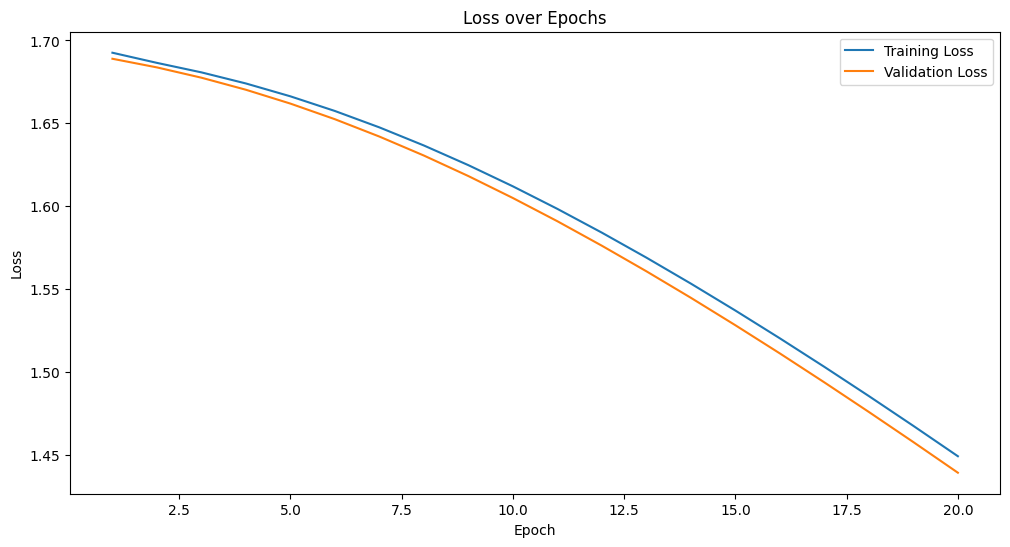

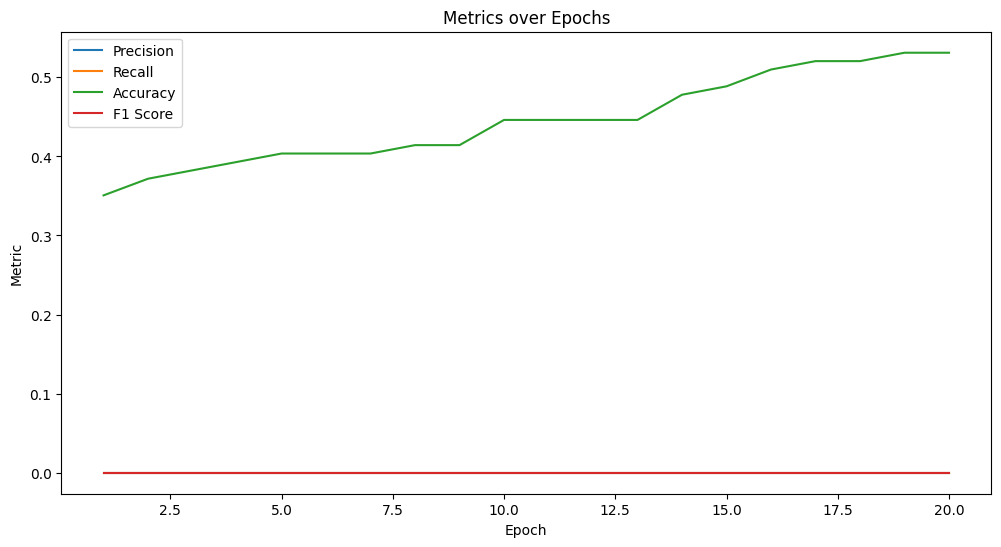

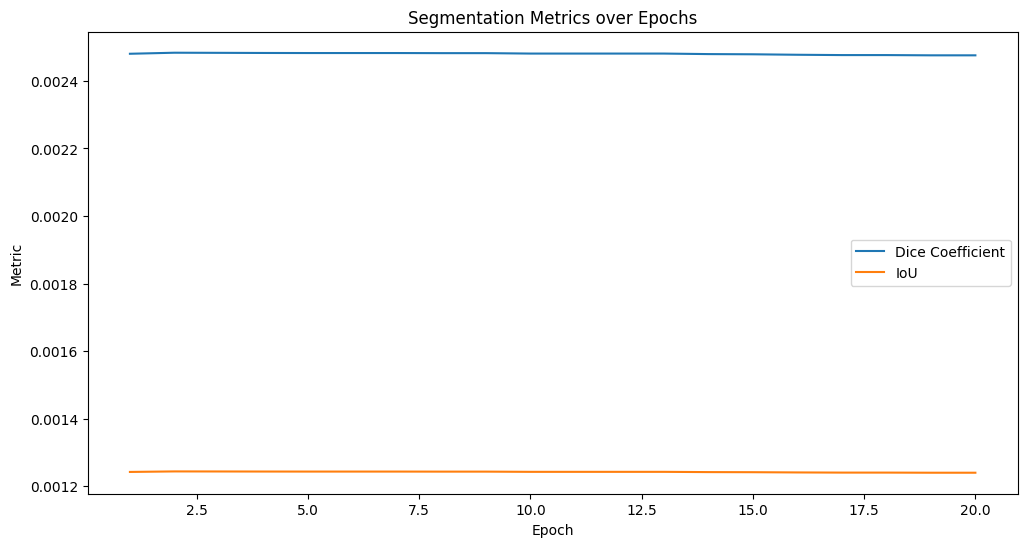

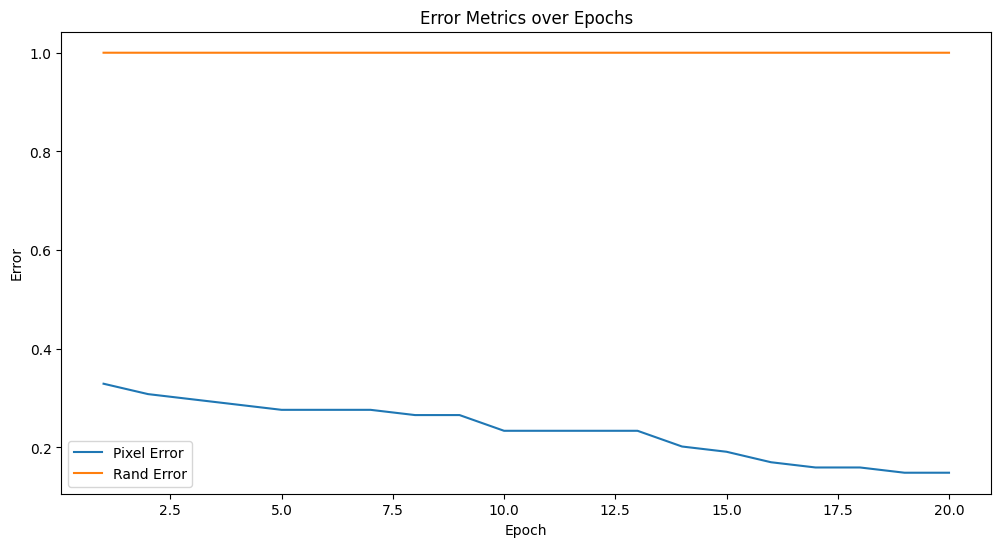

In [ ]:
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12, 6))
plt.plot(epochs, train_loss_data, label='Training Loss')
plt.plot(epochs, val_loss_data, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss over Epochs')
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(epochs, precision_data, label='Precision')
plt.plot(epochs, recall_data, label='Recall')
plt.plot(epochs, accuracy_data, label='Accuracy')
plt.plot(epochs, f1_data, label='F1 Score')
plt.xlabel('Epoch')
plt.ylabel('Metric')
plt.legend()
plt.title('Metrics over Epochs')
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(epochs, dice_coeff_data, label='Dice Coefficient')
plt.plot(epochs, iou_data, label='IoU')
plt.xlabel('Epoch')
plt.ylabel('Metric')
plt.legend()
plt.title('Segmentation Metrics over Epochs')
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(epochs, pixel_error_data, label='Pixel Error')
plt.plot(epochs, rand_error_data, label='Rand Error')
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.legend()
plt.title('Error Metrics over Epochs')
plt.show()


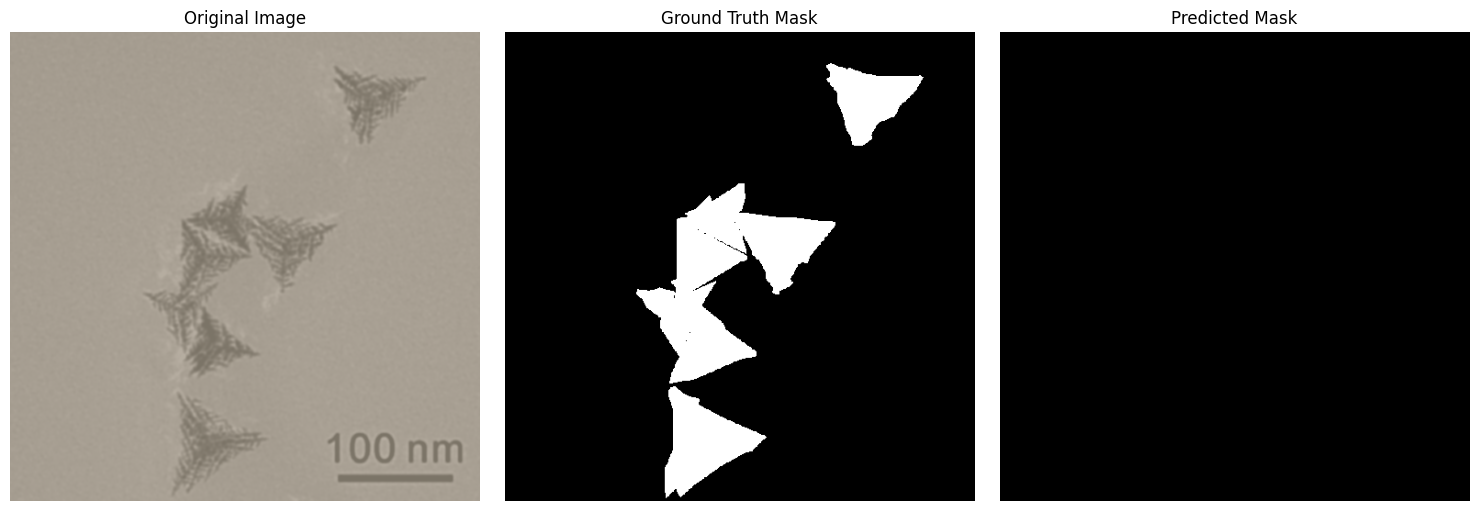

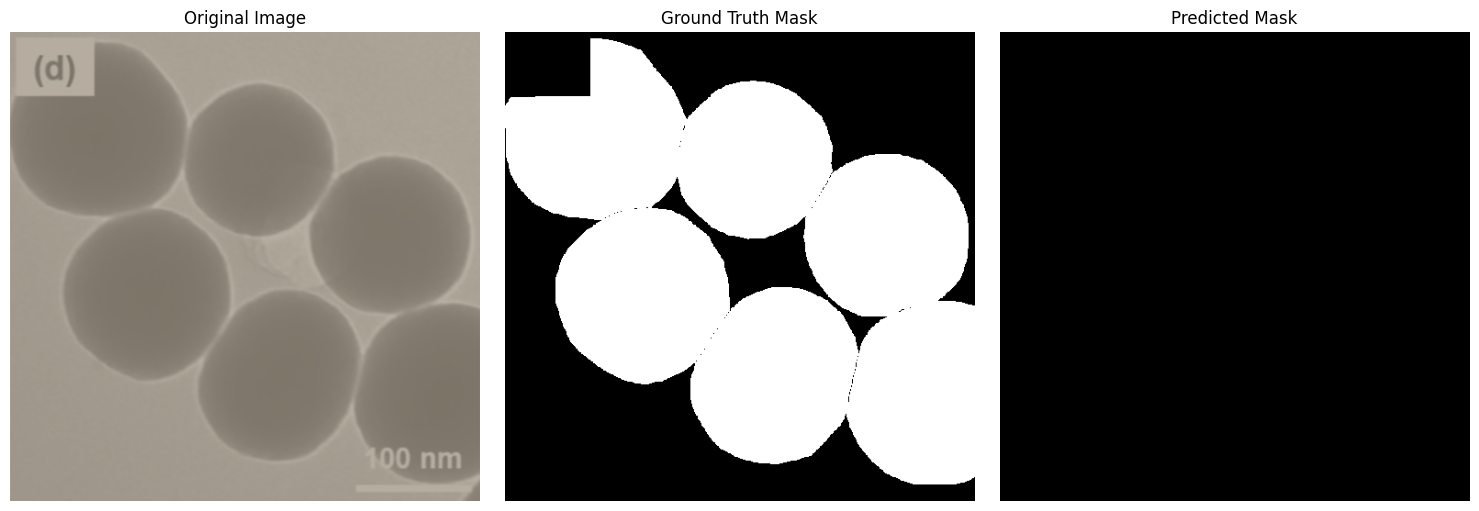

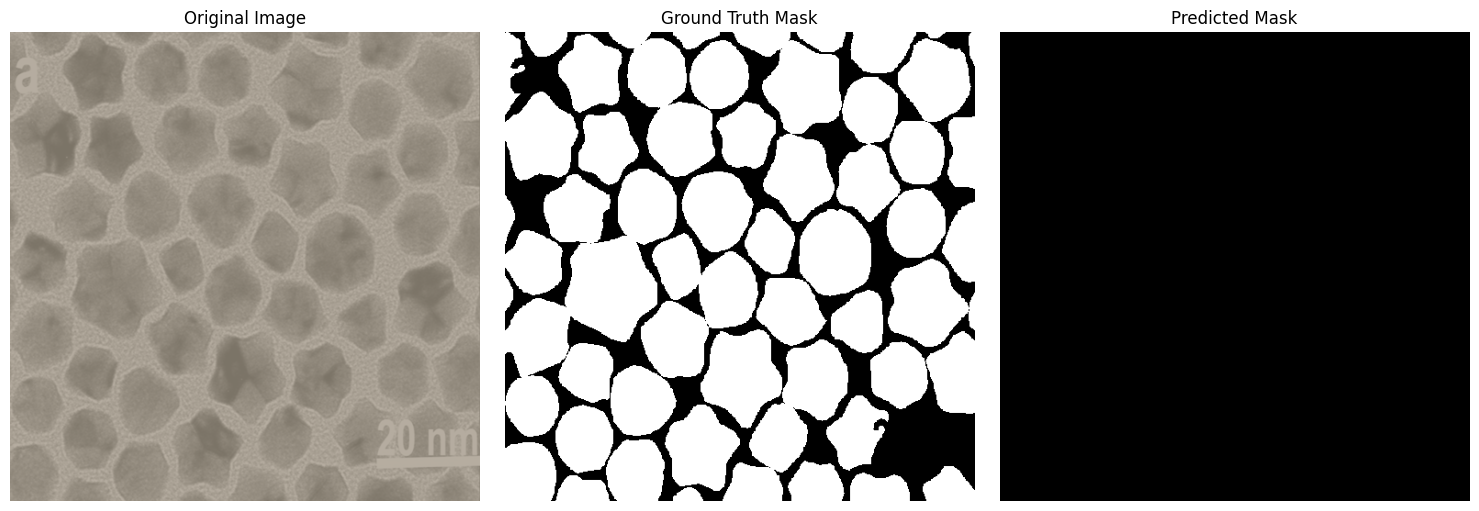

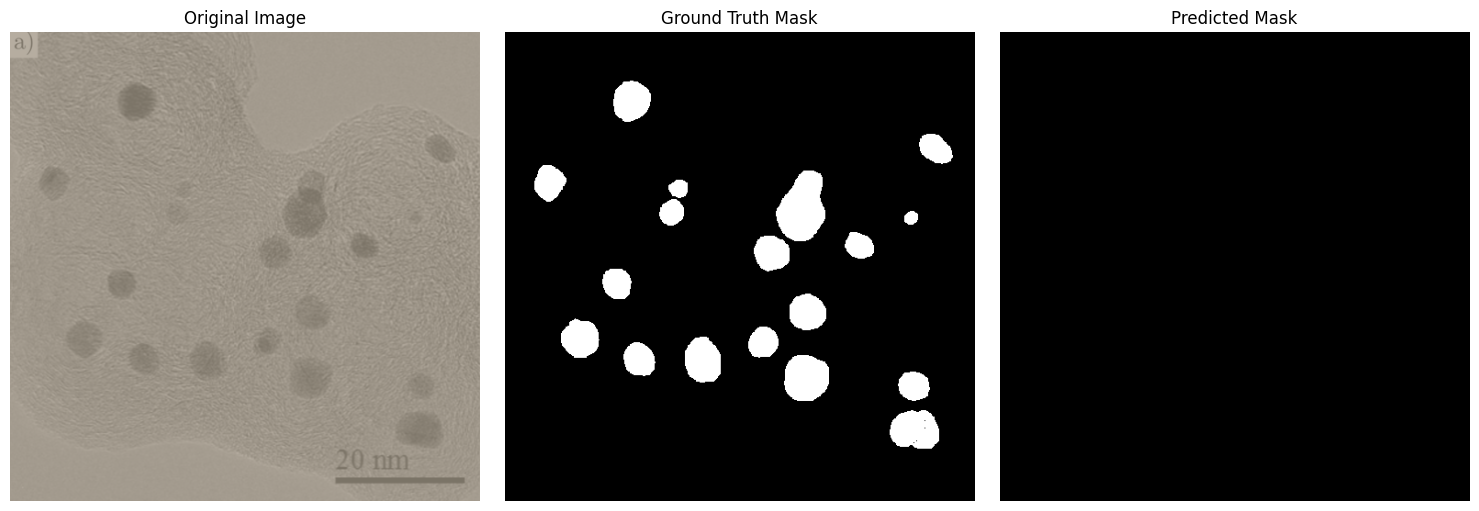

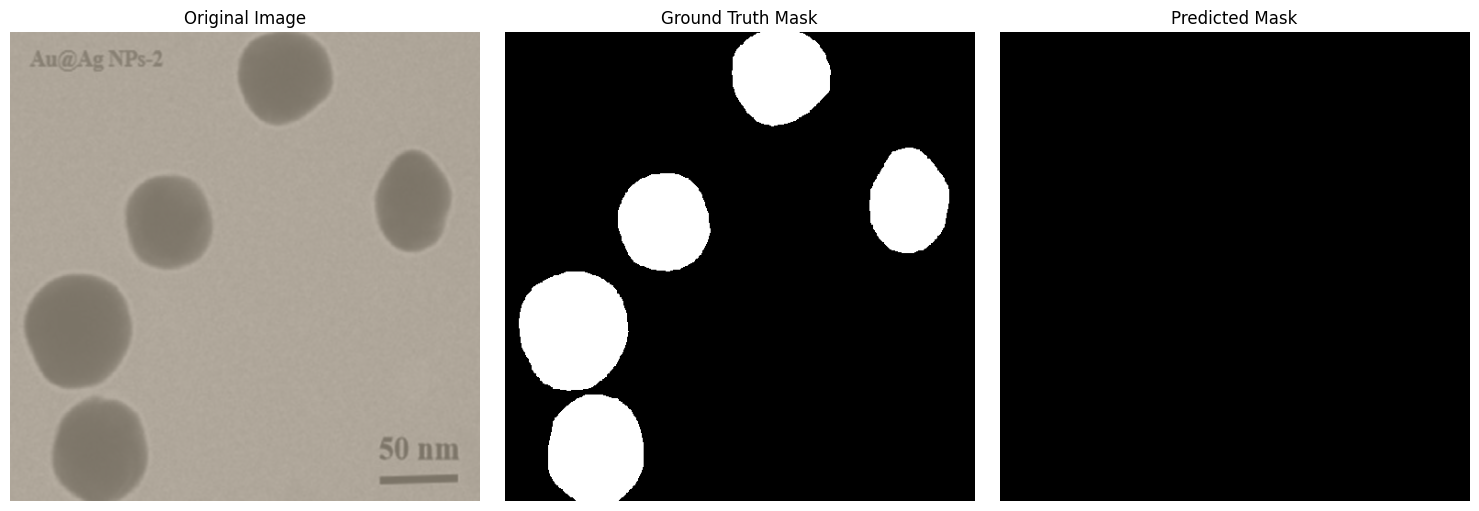

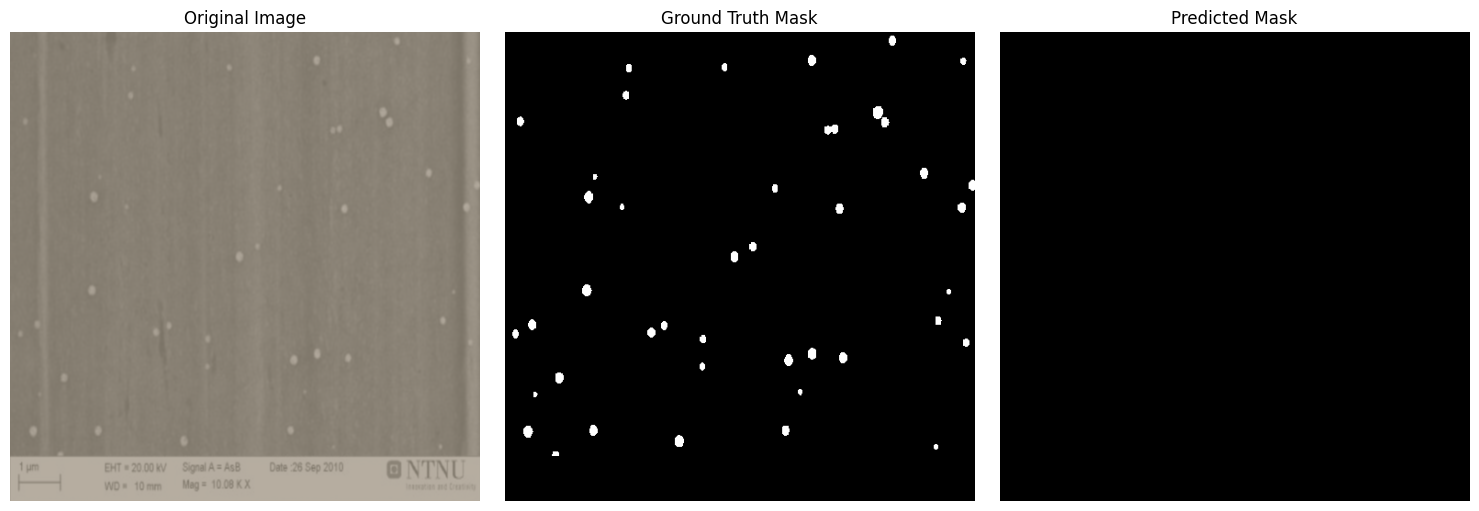

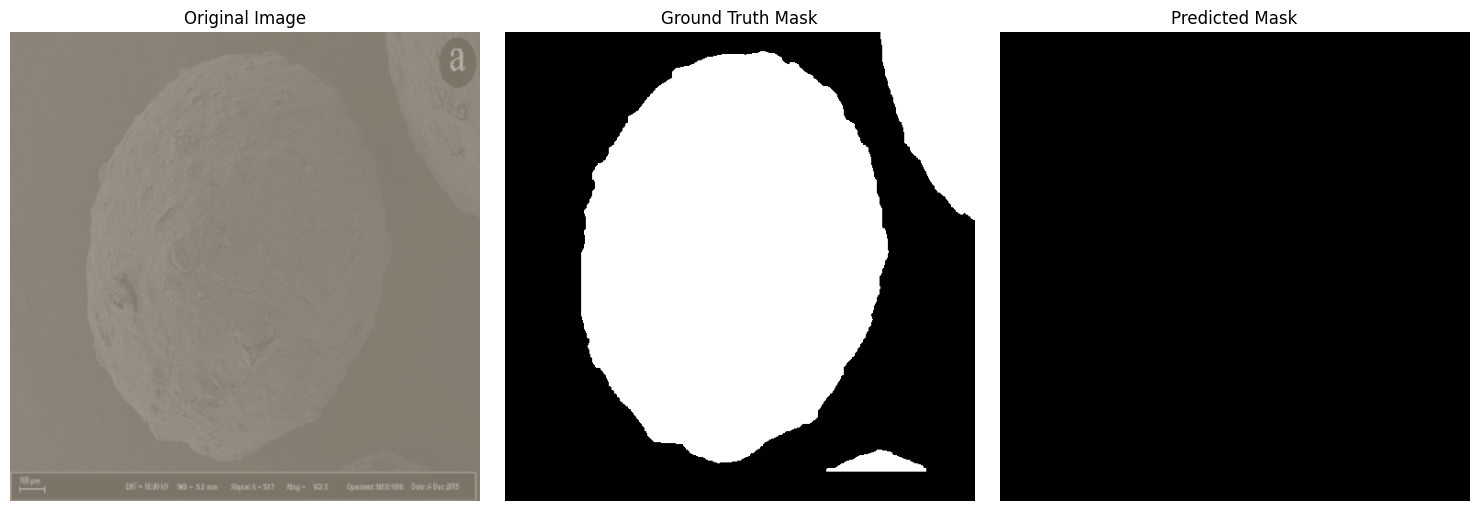

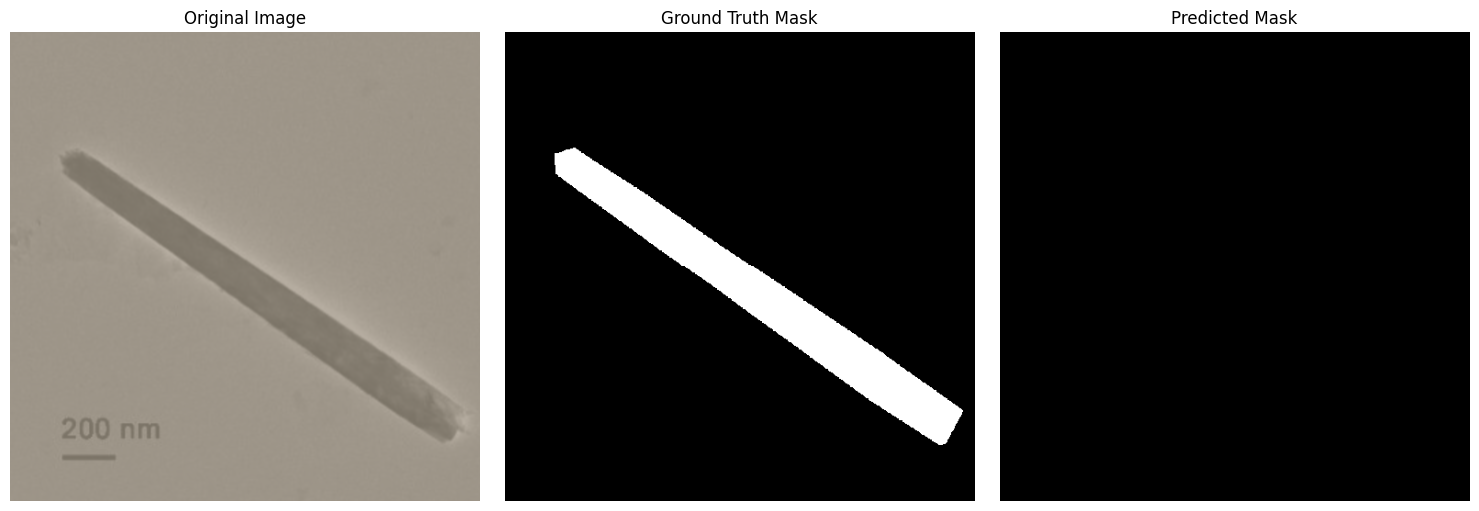

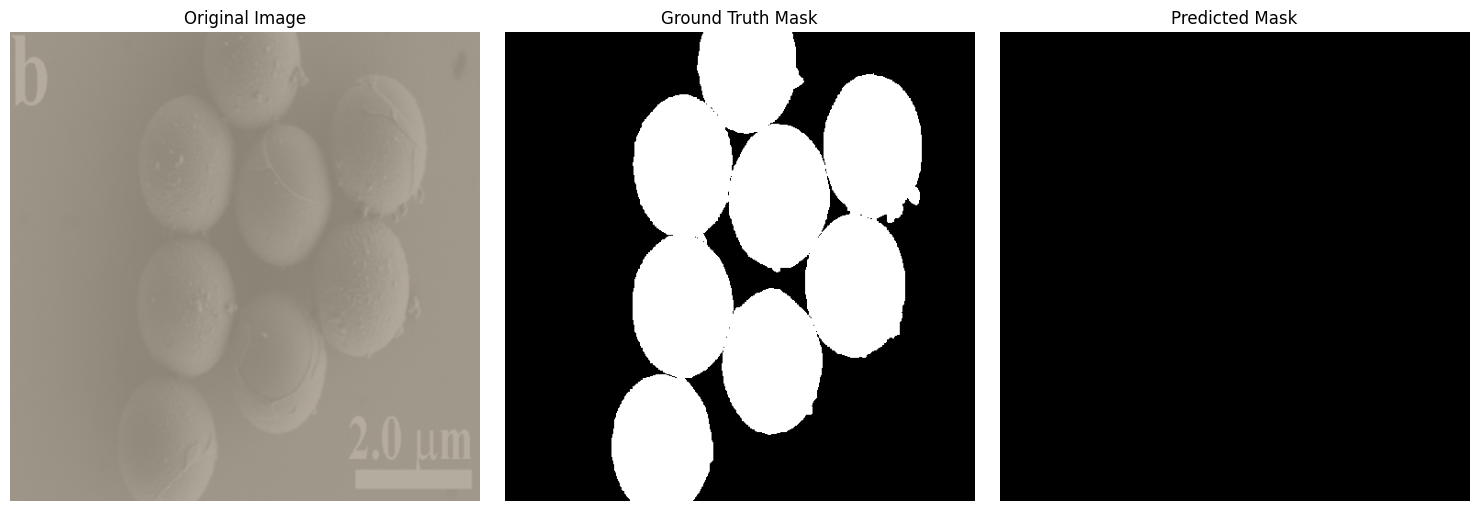

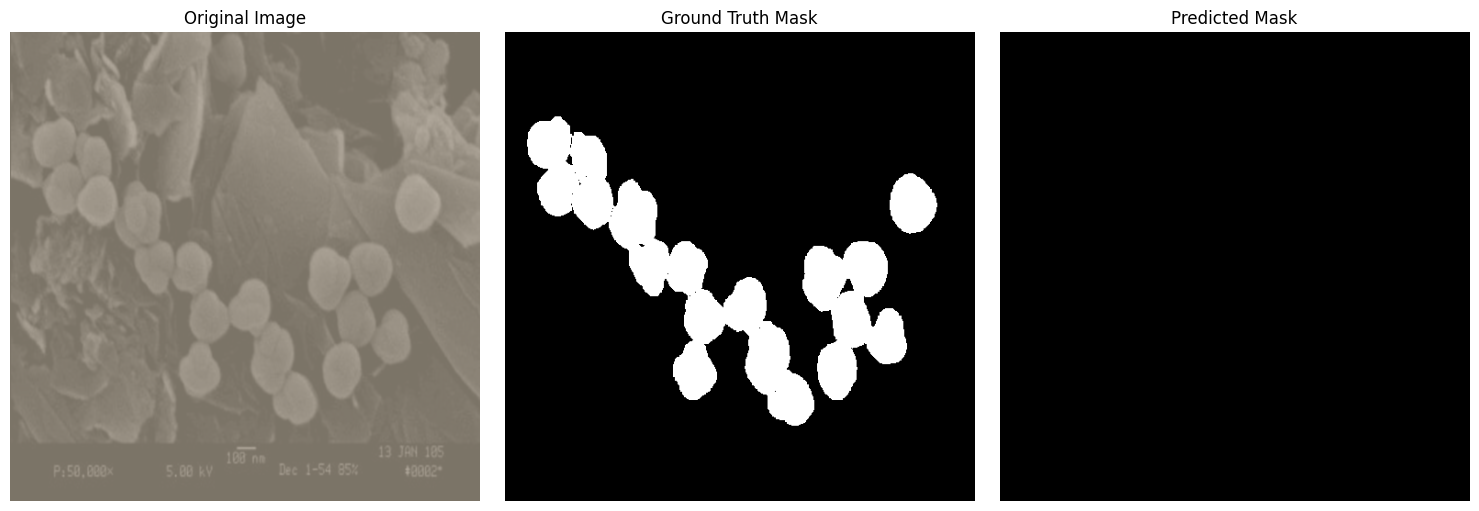

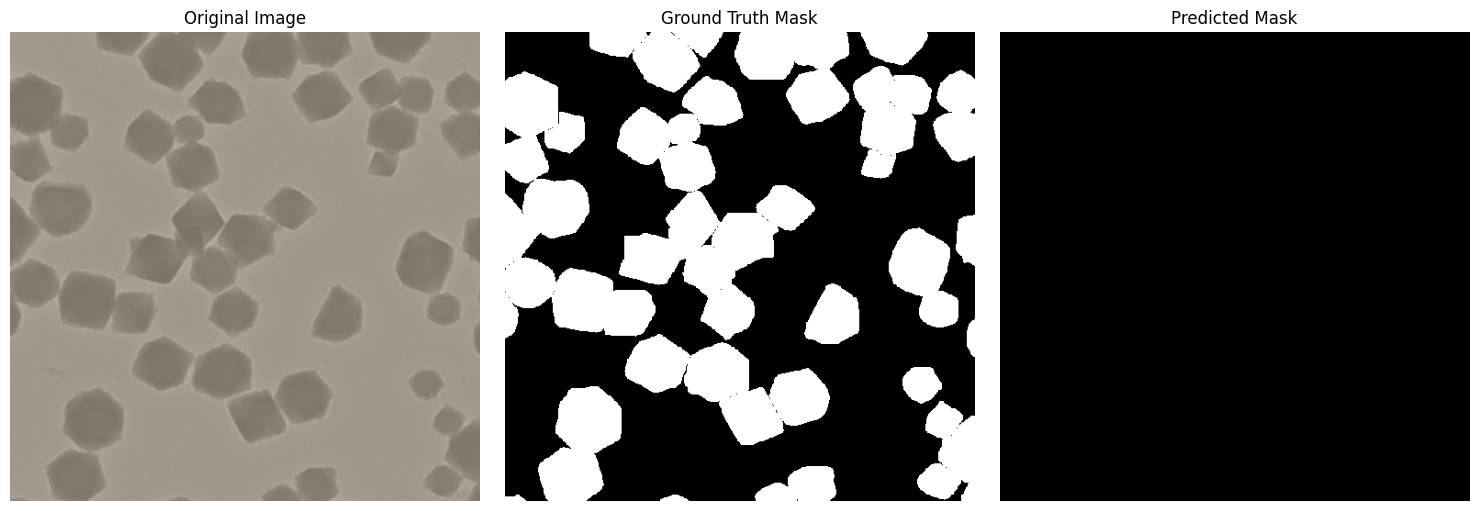

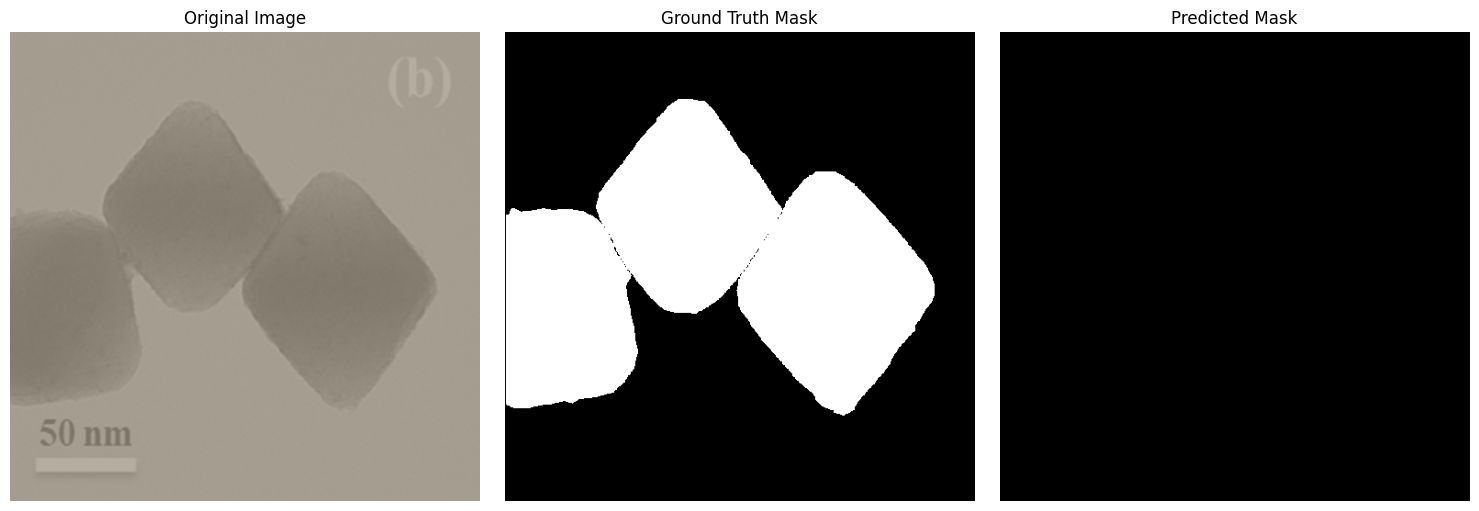

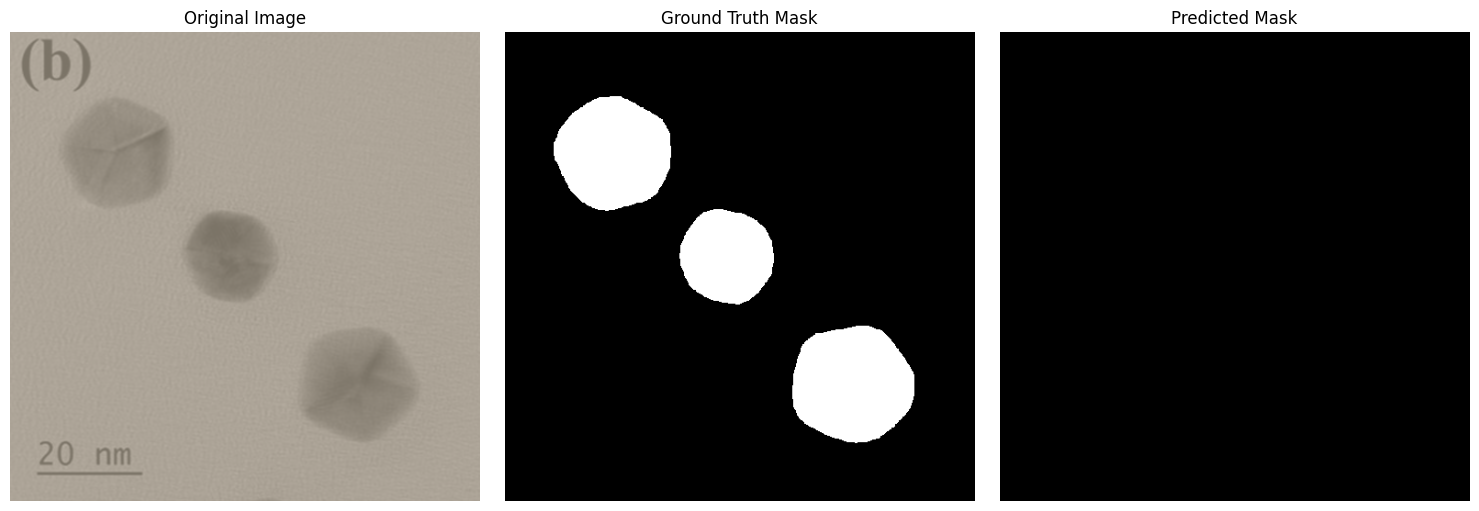

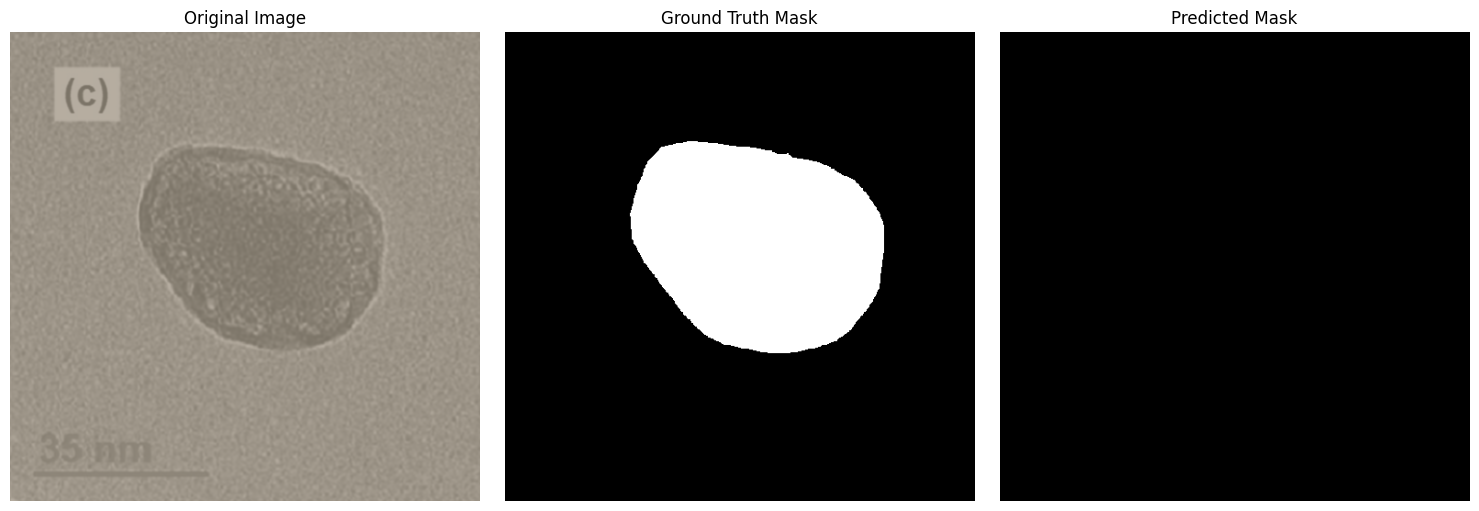

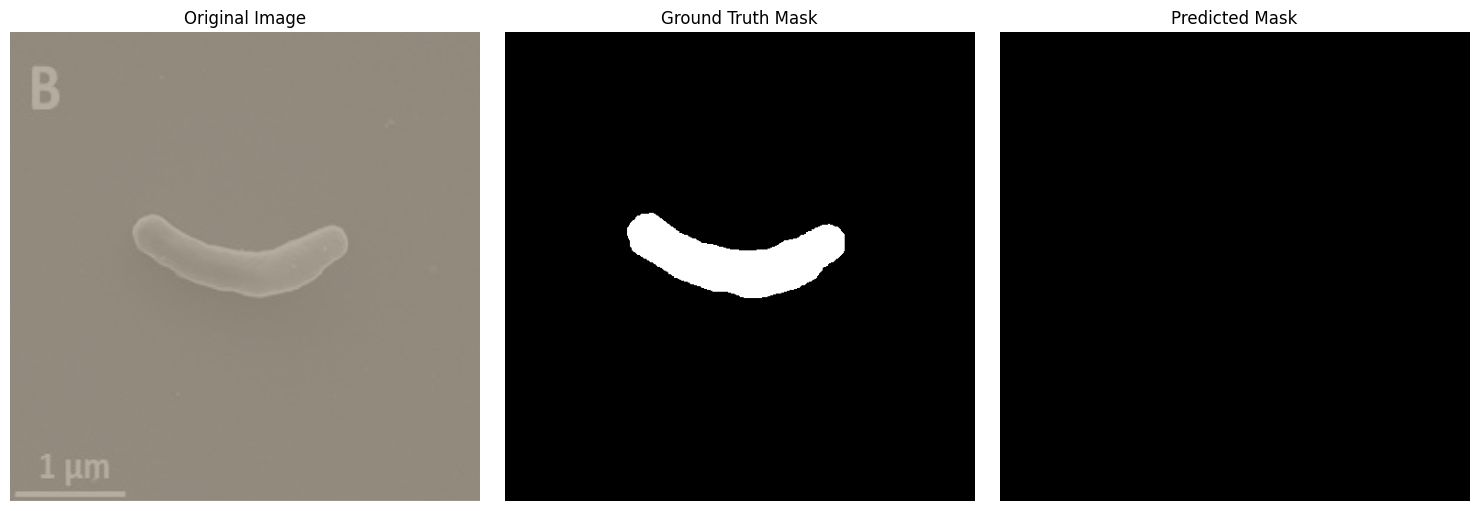

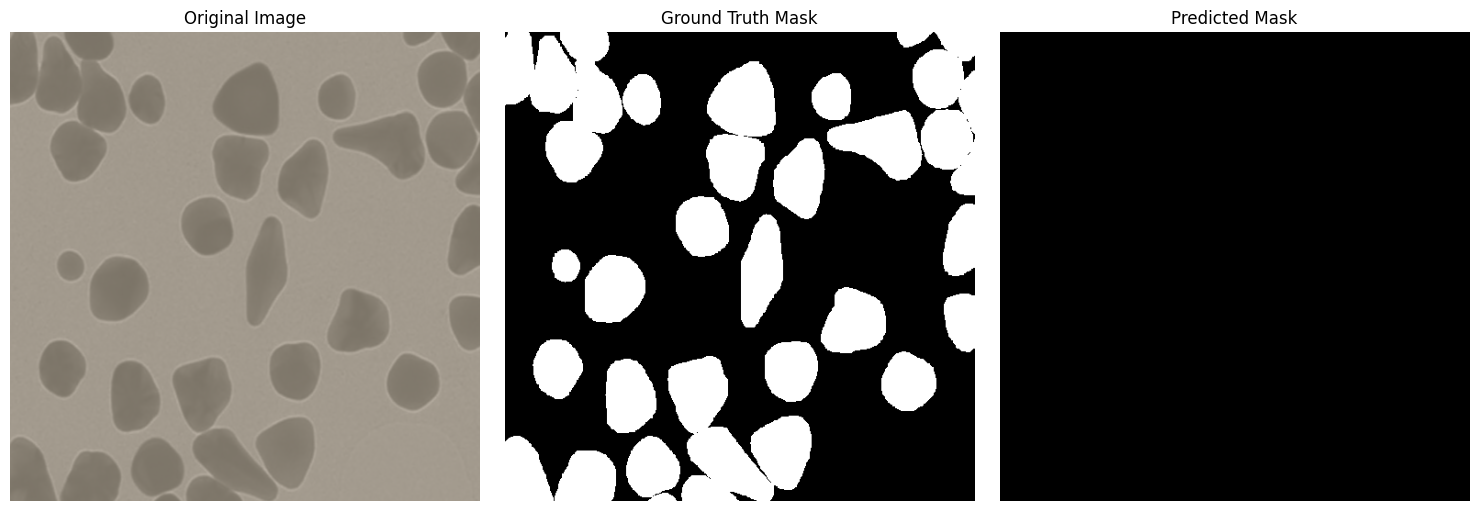

In [ ]:
# Set the model to evaluation mode
model.eval()

# Get a batch of images and masks from the test loader
images, masks = next(iter(test_loader))
images = images.to(config.device)
masks = masks.to(config.device)

# Run the model on the images
with torch.no_grad():
    outputs = model(images)
    if isinstance(outputs, dict):
        outputs = outputs['out']
    outputs = outputs.squeeze(1)  # Remove channel dimension if necessary

    # Apply sigmoid activation to get probabilities between 0 and 1
    probs = torch.sigmoid(outputs)

# Threshold probabilities to get binary masks
pred_masks = (probs > 0.5).float()

# Move data to CPU and convert to NumPy arrays for plotting
images = images.cpu()
masks = masks.cpu()
pred_masks = pred_masks.cpu()

# Denormalize images for visualization if you normalized them during preprocessing
mean = np.array([0.485, 0.456, 0.406])  # ImageNet mean
std = np.array([0.229, 0.224, 0.225])   # ImageNet std

batch_size = images.shape[0]

for i in range(batch_size):
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))

    # Original Image
    img = images[i].permute(1, 2, 0).numpy()  # Change shape from [C, H, W] to [H, W, C]
    img = img * std + mean  # Denormalize
    img = np.clip(img, 0, 1)  # Clip values to [0, 1] range
    ax[0].imshow(img)
    ax[0].set_title('Original Image')
    ax[0].axis('off')

    # Ground Truth Mask
    gt_mask = masks[i].numpy()
    ax[1].imshow(gt_mask, cmap='gray')
    ax[1].set_title('Ground Truth Mask')
    ax[1].axis('off')

    # Predicted Mask
    pred_mask = pred_masks[i].numpy()
    ax[2].imshow(pred_mask, cmap='gray')
    ax[2].set_title('Predicted Mask')
    ax[2].axis('off')

    plt.tight_layout()
    plt.show()
